 # 25.Use Cats and Dogs dataset to train a DL model  
 in https://www.kaggle.com/tongpython/cat-and-dog/code,
 provide the training code and accuracy of the validation.

 数据预处理：基于ImageNet的思路进行数据的裁剪和归一化。   
 经过多次调试，最终使用了预训练的ResNet，去掉最后一层，加上自己设定的全连接层，得到了不错的效果。

In [2]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.models.resnet import resnet18
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim.lr_scheduler import *
 
class DogCat(data.Dataset):
    def __init__(self, root,size, transform=None, train=True, test=False):
        self.test = test
        self.train = train
        self.transform = transform
        self.root = root
        self.size = 2 * size
 
    def __getitem__(self, index):
        if index % 2 == 0:  
            path = self.root + "cats/cat."
            label = 1
        else:
            path = self.root + "dogs/dog."
            label = 0
            # 狗的label设为0，猫的设为1
        index = index//2 + 1
        if self.train:
            path = path + str(index) + ".jpg"
        elif self.test:
            path = path + str(4000+index) + ".jpg"
        img = Image.open(path)
        img = self.transform(img)
      
        label = torch.tensor(label,dtype = torch.long)
               
        return img, label
 
    def __len__(self):
        return self.size
 
 
# 处理训练集
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # 先调整图片大小至256x256
    transforms.RandomCrop((224, 224)),  # 再随机裁剪到224x224
    transforms.RandomHorizontalFlip(),  # 随机的图像水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2225))  # 归一化，数值是用ImageNet给出的数值
])
 
# 处理测试集
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainset = DogCat('../input/cat-and-dog/training_set/training_set/',size = 4000, transform=transform_train)
testset = DogCat('../input/cat-and-dog/test_set/test_set/', size= 1000,transform=transform_test,train = False,test = True)
trainloader = data.DataLoader(trainset, batch_size=20, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=20, shuffle=False, num_workers=0)

class Net(torch.nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        # 取掉model的后1层
        self.resnet_layer = torch.nn.Sequential(*list(model.children())[:-1])
        self.Linear_layer = torch.nn.Linear(512, 2) #加上一层参数修改好的全连接层
 
    def forward(self, x):
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        return x
 
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total
 
 
def train(epoch):
    print('\nEpoch: %d' % (epoch+1))
    model.train()
    train_acc = 0.0
    for batch_idx, (img, label) in enumerate(trainloader):
        image = Variable(img.cuda())
        label = Variable(label.cuda())
        optimizer.zero_grad()
        out = model(image)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        train_acc = get_acc(out, label)
        print("Epoch:%d [%d|%d] loss:%f accuracy:%f" % (epoch+1, batch_idx, len(trainloader), loss.mean(), train_acc))
 
 
def test(epoch):
    print("\nTest Epoch: %d" % (epoch+1))
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (img, label) in enumerate(testloader):
            image = Variable(img.cuda())
            label = Variable(label.cuda())
            out = model(image)
 
            _, predicted = torch.max(out.data, 1)
 
            total += image.size(0)
            correct += predicted.data.eq(label.data).cpu().sum()
    print("Accuracy: %f " % ((1.0 * correct.numpy()) / total))
 
 

 
if __name__ =='__main__':
    resnet = resnet18(pretrained=True)
    model = Net(resnet)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)  
    criterion = torch.nn.CrossEntropyLoss()
 
    for epoch in range(2):
        train(epoch)
        test(epoch)
    


Epoch: 1
Epoch:1 [0|400] loss:0.770016 accuracy:0.600000
Epoch:1 [1|400] loss:0.895826 accuracy:0.450000
Epoch:1 [2|400] loss:0.812613 accuracy:0.550000
Epoch:1 [3|400] loss:0.884781 accuracy:0.450000
Epoch:1 [4|400] loss:0.779774 accuracy:0.500000
Epoch:1 [5|400] loss:0.698347 accuracy:0.500000
Epoch:1 [6|400] loss:0.735680 accuracy:0.400000
Epoch:1 [7|400] loss:0.637154 accuracy:0.550000
Epoch:1 [8|400] loss:0.620290 accuracy:0.550000
Epoch:1 [9|400] loss:0.441825 accuracy:0.800000
Epoch:1 [10|400] loss:0.350782 accuracy:0.900000
Epoch:1 [11|400] loss:0.325819 accuracy:0.850000
Epoch:1 [12|400] loss:0.332645 accuracy:0.850000
Epoch:1 [13|400] loss:0.353306 accuracy:0.900000
Epoch:1 [14|400] loss:0.344113 accuracy:0.850000
Epoch:1 [15|400] loss:0.259953 accuracy:0.900000
Epoch:1 [16|400] loss:0.399442 accuracy:0.800000
Epoch:1 [17|400] loss:0.178646 accuracy:1.000000
Epoch:1 [18|400] loss:0.149630 accuracy:0.950000
Epoch:1 [19|400] loss:0.163787 accuracy:0.950000
Epoch:1 [20|400] los

Epoch:1 [166|400] loss:0.010164 accuracy:1.000000
Epoch:1 [167|400] loss:0.024619 accuracy:1.000000
Epoch:1 [168|400] loss:0.051757 accuracy:1.000000
Epoch:1 [169|400] loss:0.096059 accuracy:0.950000
Epoch:1 [170|400] loss:0.159582 accuracy:0.900000
Epoch:1 [171|400] loss:0.020729 accuracy:1.000000
Epoch:1 [172|400] loss:0.021373 accuracy:1.000000
Epoch:1 [173|400] loss:0.062499 accuracy:0.950000
Epoch:1 [174|400] loss:0.083115 accuracy:1.000000
Epoch:1 [175|400] loss:0.018230 accuracy:1.000000
Epoch:1 [176|400] loss:0.022336 accuracy:1.000000
Epoch:1 [177|400] loss:0.018537 accuracy:1.000000
Epoch:1 [178|400] loss:0.116192 accuracy:0.950000
Epoch:1 [179|400] loss:0.139999 accuracy:0.950000
Epoch:1 [180|400] loss:0.169091 accuracy:0.900000
Epoch:1 [181|400] loss:0.065201 accuracy:1.000000
Epoch:1 [182|400] loss:0.171178 accuracy:0.900000
Epoch:1 [183|400] loss:0.081159 accuracy:0.950000
Epoch:1 [184|400] loss:0.099816 accuracy:1.000000
Epoch:1 [185|400] loss:0.026335 accuracy:1.000000


Epoch:1 [330|400] loss:0.021675 accuracy:1.000000
Epoch:1 [331|400] loss:0.072193 accuracy:0.950000
Epoch:1 [332|400] loss:0.019889 accuracy:1.000000
Epoch:1 [333|400] loss:0.064488 accuracy:0.950000
Epoch:1 [334|400] loss:0.015640 accuracy:1.000000
Epoch:1 [335|400] loss:0.006458 accuracy:1.000000
Epoch:1 [336|400] loss:0.115120 accuracy:0.950000
Epoch:1 [337|400] loss:0.019719 accuracy:1.000000
Epoch:1 [338|400] loss:0.038205 accuracy:0.950000
Epoch:1 [339|400] loss:0.004743 accuracy:1.000000
Epoch:1 [340|400] loss:0.074466 accuracy:0.950000
Epoch:1 [341|400] loss:0.008389 accuracy:1.000000
Epoch:1 [342|400] loss:0.031282 accuracy:1.000000
Epoch:1 [343|400] loss:0.026845 accuracy:1.000000
Epoch:1 [344|400] loss:0.025534 accuracy:1.000000
Epoch:1 [345|400] loss:0.015851 accuracy:1.000000
Epoch:1 [346|400] loss:0.027266 accuracy:1.000000
Epoch:1 [347|400] loss:0.007142 accuracy:1.000000
Epoch:1 [348|400] loss:0.101529 accuracy:0.950000
Epoch:1 [349|400] loss:0.073049 accuracy:0.950000


Epoch:2 [97|400] loss:0.307710 accuracy:0.850000
Epoch:2 [98|400] loss:0.027068 accuracy:1.000000
Epoch:2 [99|400] loss:0.037812 accuracy:1.000000
Epoch:2 [100|400] loss:0.003746 accuracy:1.000000
Epoch:2 [101|400] loss:0.021193 accuracy:1.000000
Epoch:2 [102|400] loss:0.009801 accuracy:1.000000
Epoch:2 [103|400] loss:0.025021 accuracy:1.000000
Epoch:2 [104|400] loss:0.101931 accuracy:0.950000
Epoch:2 [105|400] loss:0.012605 accuracy:1.000000
Epoch:2 [106|400] loss:0.078792 accuracy:0.950000
Epoch:2 [107|400] loss:0.056355 accuracy:0.950000
Epoch:2 [108|400] loss:0.028143 accuracy:1.000000
Epoch:2 [109|400] loss:0.014980 accuracy:1.000000
Epoch:2 [110|400] loss:0.014047 accuracy:1.000000
Epoch:2 [111|400] loss:0.004981 accuracy:1.000000
Epoch:2 [112|400] loss:0.014157 accuracy:1.000000
Epoch:2 [113|400] loss:0.042551 accuracy:1.000000
Epoch:2 [114|400] loss:0.149779 accuracy:0.950000
Epoch:2 [115|400] loss:0.045227 accuracy:1.000000
Epoch:2 [116|400] loss:0.177784 accuracy:0.950000
Epo

Epoch:2 [261|400] loss:0.048986 accuracy:1.000000
Epoch:2 [262|400] loss:0.011118 accuracy:1.000000
Epoch:2 [263|400] loss:0.019116 accuracy:1.000000
Epoch:2 [264|400] loss:0.080120 accuracy:0.950000
Epoch:2 [265|400] loss:0.012231 accuracy:1.000000
Epoch:2 [266|400] loss:0.002733 accuracy:1.000000
Epoch:2 [267|400] loss:0.010985 accuracy:1.000000
Epoch:2 [268|400] loss:0.008909 accuracy:1.000000
Epoch:2 [269|400] loss:0.049268 accuracy:0.950000
Epoch:2 [270|400] loss:0.008201 accuracy:1.000000
Epoch:2 [271|400] loss:0.015530 accuracy:1.000000
Epoch:2 [272|400] loss:0.011642 accuracy:1.000000
Epoch:2 [273|400] loss:0.013593 accuracy:1.000000
Epoch:2 [274|400] loss:0.016445 accuracy:1.000000
Epoch:2 [275|400] loss:0.090874 accuracy:0.950000
Epoch:2 [276|400] loss:0.002377 accuracy:1.000000
Epoch:2 [277|400] loss:0.124830 accuracy:0.950000
Epoch:2 [278|400] loss:0.047722 accuracy:0.950000
Epoch:2 [279|400] loss:0.025718 accuracy:1.000000
Epoch:2 [280|400] loss:0.030030 accuracy:1.000000


训练一个Epoch的效果就已经非常好了，最终的准确率能达到98.5%左右。

展示一张照片试试：

cat


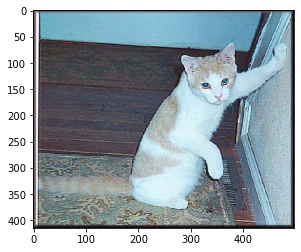

In [3]:
testset = DogCat('../input/cat-and-dog/test_set/test_set/', size= 1,transform=transform_test,train = False,test = True)
testloader = data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)
with torch.no_grad():
        for batch_idx, (img, label) in enumerate(testloader):
            if batch_idx >0:
                break
            image = Variable(img.cuda())
            label = Variable(label.cuda())
            out = model(image)
            
            _, predicted = torch.max(out.data, 1)
            
            im = Image.open("../input/cat-and-dog/test_set/test_set/cats/cat.4001.jpg")
            plt.imshow(im)
            if predicted[0].item()==1 :
                print("cat")
            else:
                print("dog")

# Discussion on beneficial improvements of the model components or training strategies  
Model components:  

我觉得要解决这种问题，建立一个合适甚至可以说强大的模型是很重要的。我最开始使用的是自己设计的CNN模型，使用3x3卷积核，中间进行池化，利用relu函数激活，最后接入线性层进行二分类。但是这样会使得超参数过多，对于我这种新手来说，调参太困难了，而且也十分令人沮丧，因为甚至网络分类的正确率还没有达到50%（对于该数据集来说，一直猜测是猫或者狗都有50%的准确率），所以最后我并没有动力继续调整。  

最终我选用的是预训练的Resnet-18模型，去掉最后一层，接入线性层使之能够解决该任务对应的猫狗二分类问题，果然分类的效果好了很多。所以不一定自己设计就表现更好，站在巨人的肩膀上能够做得更好，除了Resnet-18，AlexNet也是不错的选择，我的室友就是借鉴了AlexNet的思路很好地完成了这个问题。

Training strategies:  

**数据预处理很重要！** 在训练DL模型时，普遍的优化方法是梯度下降法，所以对于数据进行标准化是很重要的。我采用的是ImageNet的思路进行Transform，果然梯度下降快了很多。对于UCI Wine这样一个小数据集来说，做标准化都可以使梯度下降并收敛的速度更快，更何况这样一个相对较大的数据集。 然后也可以做一点数据增强，虽然在这里没什么用，我当作熟悉函数的练习做了一下Resize和RandomCrop，可能在数据比较小或者特征比较单一的情况下效果更好。   

优化器的参数选择可以用学界的常用数据，例如Adam的1e-3，5e-4，1e-4的学习率，SGD的1e-3学习率，0.9的动量等等之类的，对于大多数模型来说这样设置都可以，在一定程度上避免了无效的调整。

我觉得在面对一个问题训练DL模型时，可以遵循以下的步骤：  
1.快速搭建一个（细节可能不那么完善的）模型并进行迭代，看一看效果怎么样，效果实在是太差了就换一个模型。  
2.观察模型的训练情况，如果是在训练集的正确率太低，说明模型的偏差很大（欠拟合），可以增大训练集的样本量（对于这题来说不可能，除非允许使用外部数据），训练更大的神经网络，或者切换更好的优化算法，例如从SGD切换到Adam之类；如果是在测试集上正确率太低，说明模型的方差很大（过拟合），可以加入正则化惩罚，改写损失函数，或者用early stopping之类的手段观察。很多时候分析不奏效或者太过繁琐的话，每个调整方法都试一试也是不错的选择。
3.找到了合适的学习率等等之后，可以先用粗网格的训练方式，训练1-5个epoch；之后使用更细的网格，训练更长时间，直到得到想要的结果。

